In [669]:
import numpy as np
import seaborn as sb
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import sympy as sp
import math

In [670]:
def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

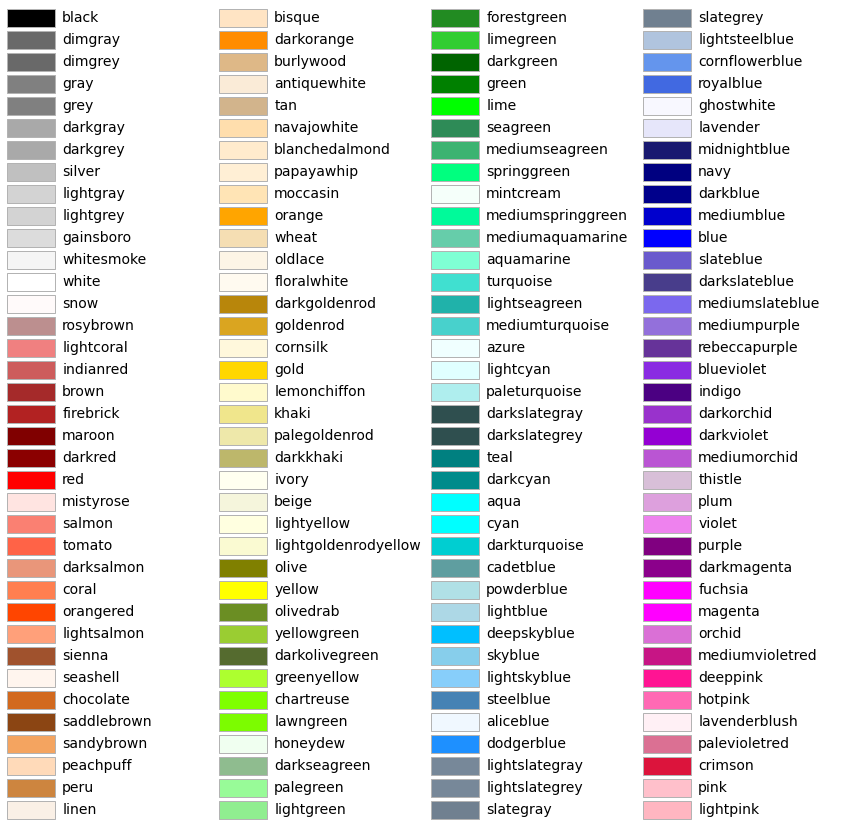

In [671]:
plot_colortable(mcolors.CSS4_COLORS)
plt.show()

In [1425]:
df = pd.read_csv('../DATA/all_out.csv') #loading pre-data
t  = pd.read_csv('../DATA/time.csv') #loading pre-data
t = t.to_numpy()

In [1426]:
y = df[df.columns[0]]
z = df[df.columns[1]]
phi = df[df.columns[2]]
v = df[df.columns[3]]
w = df[df.columns[4]]
phi_dot = df[df.columns[5]]
u1 = df[df.columns[6]]
u2 = df[df.columns[7]]

In [1427]:
dt = t[1] - t[0]
dt = dt[0]
dt

0.01

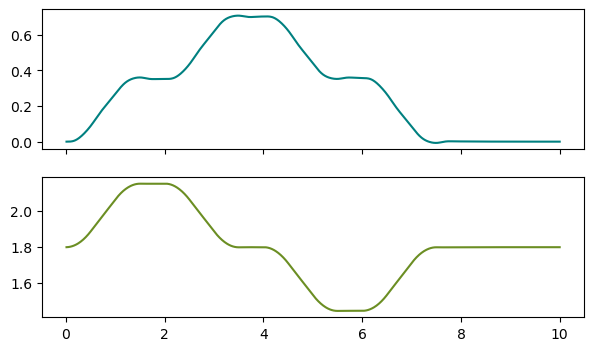

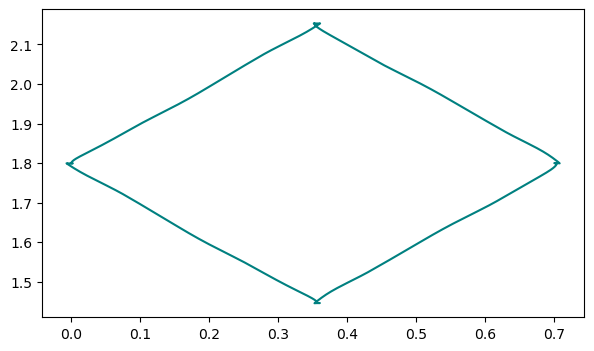

In [1428]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 4))
axs[0].plot(t,y, color= 'teal')
axs[1].plot(t,z, color= 'olivedrab')
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(7, 4))
axs.plot(y,z, color= 'teal')

In [1429]:
X = np.stack((y, z, phi, v, w, phi_dot), axis=-1)
U = np.stack((u1, u2), axis=-1)

In [1430]:
X.shape

(1000, 6)

In [1431]:
U.shape

(1000, 2)

In [1432]:
differentiation_method = ps.FiniteDifference(order=1)

In [1433]:
poly_library = ps.PolynomialLibrary(degree=1)
fourier_library = ps.FourierLibrary(n_frequencies=1)
generalized_library = poly_library 

In [1434]:
optimizer = ps.STLSQ(threshold=0.9)

In [1435]:
model = ps.SINDy(differentiation_method=differentiation_method,
                feature_library=generalized_library,
                optimizer=optimizer,
                feature_names=['y','z', 'phi', 'yd', 'zd', 'phid', 'u1', 'u2'])

In [1436]:
model.fit(X, u = U, t = dt)

SINDy(differentiation_method=FiniteDifference(order=1),
      feature_library=PolynomialLibrary(degree=1),
      feature_names=['y', 'z', 'phi', 'yd', 'zd', 'phid', 'u1', 'u2'],
      optimizer=STLSQ(threshold=0.9))

In [1437]:
model.print()

(y)' = 1.000 yd
(z)' = 1.000 zd
(phi)' = 1.000 phid + 20.000 u2
(yd)' = -9.753 phi
(zd)' = -9.827 1 + 5.557 u1
(phid)' = 4000.000 u2


In [1438]:
x_dot_test_predicted = model.predict(X, u=U)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(X, t=dt)

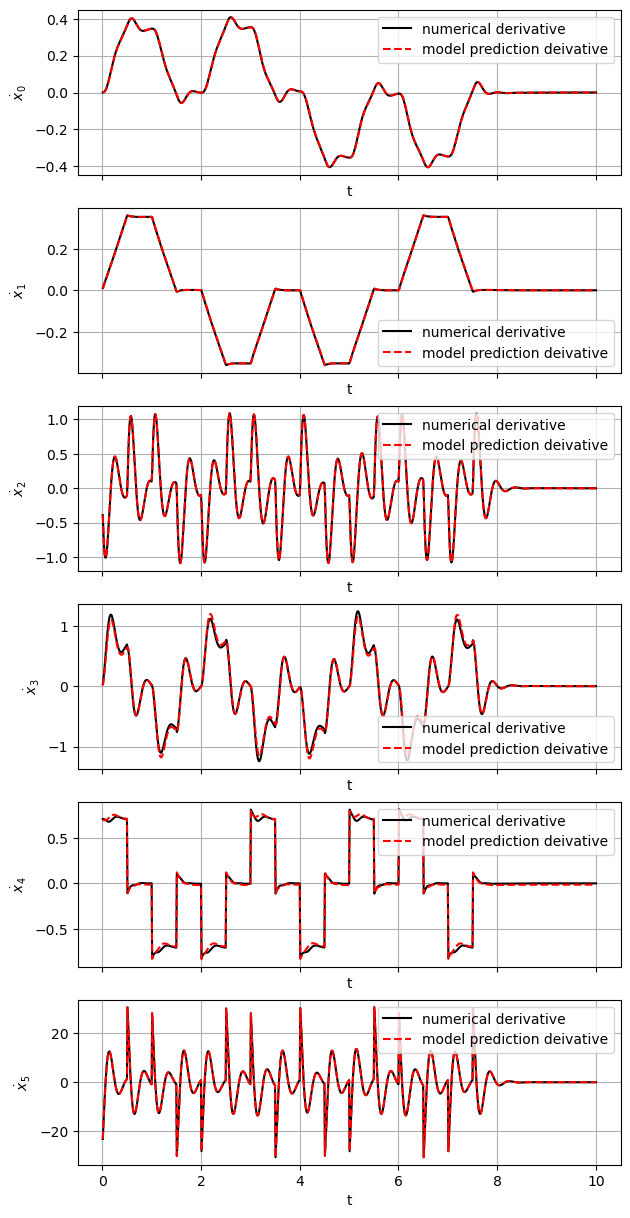

In [1439]:
fig, axs = plt.subplots(X.shape[1], 1, sharex=True, figsize=(7, 15))
for i in range(X.shape[1]):
    axs[i].plot(t, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t, x_dot_test_predicted[:, i],
                'r--', label='model prediction deivative')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
    axs[i].grid()
fig.show()

In [1440]:
x0_test = np.array([0.0, 1.8, 0.0, 0.0, 0.0, 0.0])

In [1441]:
t = np.arange(0, 10, dt)

In [1442]:
x_test_sim = model.simulate(x0_test,
                            t,
                            u = U,
                           integrator='odeint')

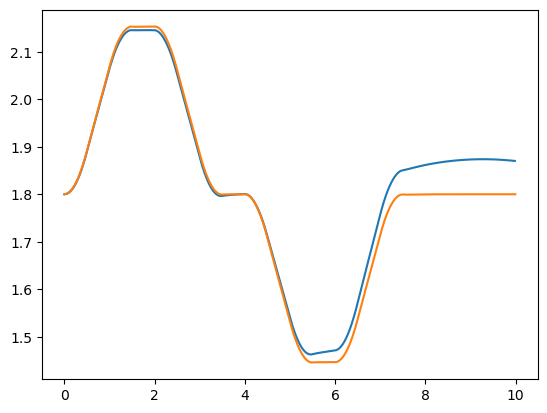

In [1445]:
t = np.arange(0, 10-dt, dt)
plt.plot(t, x_test_sim[:, 1])
t = np.arange(0, 10, dt)
plt.plot(t, X[:, 1])